# Multi-Architecture SQLite Performance Analysis

This notebook analyzes combined timing results from multiple architectures (AMD64, ARM64, RISC-V), comparing native execution vs WebAssembly across different container runtimes and WASM engines.

**Setup Instructions:**
1. Activate your virtual environment: `source venv/bin/activate`
2. Ensure you have combined results: `python3 combine_results.py`
3. Run this notebook: `jupyter notebook analyze_multiarch_results.ipynb`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Data Loading and Preparation

In [ ]:
# Load the CSV data - with automatic combination of architecture files
import glob
import os

def combine_architecture_csvs():
    """Combine timing results from amd64, arm64, and riscv64 into one dataframe."""
    
    # Define the architecture files to combine
    arch_files = {
        'amd64': 'amd64-timing_results.csv',
        'arm64': 'arm64-timing_results.csv', 
        'riscv64': 'riscv64-timing_results.csv'
    }
    
    combined_data = []
    found_files = []
    
    print("🔍 Looking for architecture-specific timing files...")
    
    for arch, filename in arch_files.items():
        if os.path.exists(filename):
            print(f"✅ Found: {filename}")
            try:
                # Read the CSV file
                df = pd.read_csv(filename, quoting=1)
                
                # Add architecture column
                df['Architecture'] = arch.upper()
                
                # Reorder columns to have Architecture near the beginning
                cols = df.columns.tolist()
                # Move Architecture to be the second column (after Runtime)
                if 'Runtime' in cols:
                    runtime_idx = cols.index('Runtime')
                    cols.insert(runtime_idx + 1, cols.pop(cols.index('Architecture')))
                else:
                    # If no Runtime column, put Architecture first
                    cols.insert(0, cols.pop(cols.index('Architecture')))
                df = df[cols]
                
                combined_data.append(df)
                found_files.append(filename)
                
                print(f"   📊 Loaded {len(df)} measurements from {arch.upper()}")
                
            except Exception as e:
                print(f"❌ Error reading {filename}: {e}")
        else:
            print(f"⚠️  Not found: {filename}")
    
    if combined_data:
        # Combine all dataframes
        print(f"\\n🔄 Combining data from {len(combined_data)} architecture(s)...")
        combined_df = pd.concat(combined_data, ignore_index=True)
        print(f"📊 Total measurements: {len(combined_df)}")
        return combined_df, found_files
    else:
        return None, []

# Try to load combined CSV first, otherwise combine architecture files
combined_files = glob.glob('combined_timing_results_*.csv')
if combined_files:
    # Use the most recent combined file
    combined_files.sort(reverse=True)
    csv_file = combined_files[0]
    print(f"📁 Using existing combined results file: {csv_file}")
    try:
        df = pd.read_csv(csv_file, quoting=1)
        print(f"✅ Loaded {len(df)} measurements")
        print(f"✅ Columns: {list(df.columns)}")
    except Exception as e:
        print(f"❌ Error loading combined file: {e}")
        df = None
else:
    # Combine architecture files automatically
    print("📁 No combined file found, combining architecture-specific files...")
    df, source_files = combine_architecture_csvs()
    
    if df is not None:
        print(f"✅ Successfully combined {len(df)} measurements")
        print(f"✅ Columns: {list(df.columns)}")
        print(f"💾 Source files: {', '.join(source_files)}")
    else:
        print("❌ No valid timing files found!")
        print("Expected files: amd64-timing_results.csv, arm64-timing_results.csv, riscv64-timing_results.csv")

if df is not None:
    # Clean and prepare data
    df['Image Type'] = df['Image'].apply(lambda x: 'WebAssembly' if 'wasm' in x else 'Native')
    
    # Convert timestamps to datetime
    df['Start Time'] = pd.to_datetime(df['Start Timestamp'], unit='s')
    
    # Handle N/A values in timing columns
    timing_columns = ['Container Start to Main Time (s)', 'Main to Elapsed Time (s)']
    for col in timing_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Check if this is a multi-architecture dataset
    has_architecture = 'Architecture' in df.columns
    
    print("\\n📊 Data Summary:")
    if has_architecture:
        print("Multi-architecture dataset detected!")
        arch_runtime_summary = df.groupby(['Architecture', 'Runtime', 'Image Type']).size()
        print(arch_runtime_summary.to_string())
        print(f"\\n🏗️ Architectures: {', '.join(sorted(df['Architecture'].unique()))}")
        
        # Show WASM runtime distribution
        if 'WASM_Runtime' in df.columns:
            wasm_data = df[df['Image Type'] == 'WebAssembly']
            if not wasm_data.empty:
                wasm_runtime_dist = wasm_data.groupby(['Architecture', 'WASM_Runtime']).size()
                print(f"\\n🔧 WASM Runtime Distribution:")
                print(wasm_runtime_dist.to_string())
    else:
        print(df.groupby(['Runtime', 'Image Type']).size().to_string())
        print("\\n🏗️ Single architecture dataset")
else:
    print("❌ No data available for analysis")

In [3]:
# Display basic statistics
if df is not None:
    print("\n🔍 Data Overview:")
    display(df.head())
    
    print("\n📈 Basic Statistics:")
    numeric_cols = ['Pull Time (s)', 'Container Start to Main Time (s)', 
                   'Main to Elapsed Time (s)', 'Total Execution Time (s)', 'Host Size (MB)']
    display(df[numeric_cols].describe())


🔍 Data Overview:


,Runtime,Architecture,Image,Platform,Iteration,Start Timestamp,Pull Complete Timestamp,Execution Complete Timestamp,Pull Time (s),Container Start to Main Time (s),Main to Elapsed Time (s),Total Execution Time (s),Host Size (MB),WASM_Runtime,Image Type,Start Time
0,docker,AMD64,docker.io/matsbror/massive-sqlite-native:1.1,linux/amd64,1,1754381924,1754381926,1754381927,2.039,0.719,0.199,0.567,3.41,NaN,Native,2025-08-05 08:18:44
1,docker,AMD64,docker.io/matsbror/massive-sqlite-native:1.1,linux/amd64,2,1754381927,1754381929,1754381930,2.008,0.948,0.198,0.593,3.41,NaN,Native,2025-08-05 08:18:47
2,docker,AMD64,docker.io/matsbror/massive-sqlite-native:1.1,linux/amd64,3,1754381930,1754381932,1754381933,1.999,1.175,0.199,0.604,3.41,NaN,Native,2025-08-05 08:18:50
3,docker,AMD64,docker.io/matsbror/massive-sqlite-native:1.1,linux/amd64,4,1754381934,1754381936,1754381936,2.072,0.456,0.197,0.588,3.41,NaN,Native,2025-08-05 08:18:54
4,docker,AMD64,docker.io/matsbror/massive-sqlite-native:1.1,linux/amd64,5,1754381937,1754381939,1754381940,2.092,0.776,0.198,0.601,3.41,NaN,Native,2025-08-05 08:18:57



📈 Basic Statistics:


,Pull Time (s),Container Start to Main Time (s),Main to Elapsed Time (s),Total Execution Time (s),Host Size (MB)
count,160.000000,160.000000,160.000000,160.000000,160.000000
mean,2.210575,9.250781,13.525450,24.053094,1.078750
std,0.581050,13.978134,31.938735,33.652563,1.189423
min,1.032000,0.174000,0.195000,0.353000,0.000000
25%,1.879000,0.957500,0.328750,1.217750,0.000000
50%,2.128000,1.535000,0.829000,2.098000,0.820000
75%,2.550500,12.213000,4.054250,41.797500,1.640000
max,7.099000,45.628000,98.558000,106.422000,3.410000


## Cross-Architecture Performance Comparison

In [ ]:
if df is not None and has_architecture:
    # Create specific comparison plots as requested - WAMR only
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('SQLite Performance Comparison: Pull Times and Native vs WASM (WAMR only)', fontsize=16, fontweight='bold')
    
    # 1. Pull Times: Docker vs Containerd across three architectures
    ax1 = axes[0]
    
    # Filter data for docker and containerd only
    pull_data = df[df['Runtime'].isin(['docker', 'containerd'])].copy()
    
    if not pull_data.empty:
        sns.boxplot(data=pull_data, x='Architecture', y='Pull Time (s)', hue='Runtime', ax=ax1)
        ax1.set_title('Pull Times: Docker vs Containerd by Architecture')
        ax1.set_ylabel('Pull Time (seconds)')
        ax1.legend(title='Container Runtime')
        
        # Add mean values as text annotations
        for arch in pull_data['Architecture'].unique():
            for i, runtime in enumerate(['docker', 'containerd']):
                subset = pull_data[(pull_data['Architecture'] == arch) & (pull_data['Runtime'] == runtime)]
                if not subset.empty:
                    mean_val = subset['Pull Time (s)'].mean()
                    arch_pos = list(pull_data['Architecture'].unique()).index(arch)
                    x_pos = arch_pos + (i - 0.5) * 0.25  # Offset for hue
                    ax1.text(x_pos, mean_val + 0.1, f'{mean_val:.2f}s', 
                            ha='center', va='bottom', fontsize=9, fontweight='bold')
    else:
        ax1.text(0.5, 0.5, 'No Docker/Containerd data available', 
                ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Pull Times - No Data')
    
    # 2. Native vs WASM execution using WAMR ONLY across architectures
    ax2 = axes[1]
    
    wamr_native_data = []
    
    # Get native data (docker runtime with N/A WASM runtime)
    native_data = df[(df['Image Type'] == 'Native') & 
                     (df['Runtime'] == 'docker') & 
                     (df['WASM_Runtime'] == 'N/A')].copy()
    if not native_data.empty:
        native_data['Execution_Type'] = 'Native (Docker)'
        wamr_native_data.append(native_data)
        print(f"📊 Found {len(native_data)} native measurements")
    
    # Get WAMR WASM data only - filter specifically for WAMR
    wamr_data = df[(df['Image Type'] == 'WebAssembly') & 
                   (df['WASM_Runtime'] == 'wamr')].copy()
    if not wamr_data.empty:
        wamr_data['Execution_Type'] = 'WASM (WAMR + Containerd)'
        wamr_native_data.append(wamr_data)
        print(f"📊 Found {len(wamr_data)} WAMR measurements")
        
        # Show architecture and runtime breakdown for WAMR
        wamr_breakdown = wamr_data.groupby(['Architecture', 'Runtime']).size()
        print("WAMR measurements by architecture and runtime:")
        for (arch, runtime), count in wamr_breakdown.items():
            print(f"  {arch} + {runtime}: {count}")
    else:
        print("❌ No WAMR-specific data found")
    
    if wamr_native_data:
        comparison_data = pd.concat(wamr_native_data, ignore_index=True)
        
        sns.barplot(data=comparison_data, x='Architecture', y='Total Execution Time (s)', 
                   hue='Execution_Type', ax=ax2)
        ax2.set_title('Execution Time: Native vs WASM (WAMR) by Architecture')
        ax2.set_ylabel('Total Execution Time (seconds)')
        ax2.legend(title='Execution Type')
        
        # Add performance ratio annotations
        for arch in comparison_data['Architecture'].unique():
            native_subset = comparison_data[
                (comparison_data['Architecture'] == arch) & 
                (comparison_data['Execution_Type'] == 'Native (Docker)')
            ]
            wasm_subset = comparison_data[
                (comparison_data['Architecture'] == arch) & 
                (comparison_data['Execution_Type'] == 'WASM (WAMR + Containerd)')
            ]
            
            if not native_subset.empty and not wasm_subset.empty:
                native_mean = native_subset['Total Execution Time (s)'].mean()
                wasm_mean = wasm_subset['Total Execution Time (s)'].mean()
                ratio = wasm_mean / native_mean if native_mean > 0 else 0
                
                arch_pos = list(comparison_data['Architecture'].unique()).index(arch)
                max_val = max(native_mean, wasm_mean)
                ax2.text(arch_pos, max_val + 0.5, f'{ratio:.1f}x', 
                        ha='center', va='bottom', fontsize=10, fontweight='bold', 
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    else:
        ax2.text(0.5, 0.5, 'No Native/WAMR comparison data available', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Native vs WASM (WAMR) Execution - No Data')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison statistics
    print("\n📊 DETAILED COMPARISON STATISTICS (WAMR ONLY)")
    print("=" * 55)
    
    if not pull_data.empty:
        print("\n🚀 Pull Time Comparison (Docker vs Containerd):")
        print("-" * 45)
        pull_stats = pull_data.groupby(['Architecture', 'Runtime'])['Pull Time (s)'].agg(['mean', 'std', 'count']).round(3)
        display(pull_stats)
        
        # Calculate speed improvements
        print("\nContainerd vs Docker Pull Time Improvements:")
        for arch in pull_data['Architecture'].unique():
            docker_time = pull_data[(pull_data['Architecture'] == arch) & (pull_data['Runtime'] == 'docker')]['Pull Time (s)'].mean()
            containerd_time = pull_data[(pull_data['Architecture'] == arch) & (pull_data['Runtime'] == 'containerd')]['Pull Time (s)'].mean()
            
            if pd.notna(docker_time) and pd.notna(containerd_time) and docker_time > 0:
                improvement = ((docker_time - containerd_time) / docker_time) * 100
                if improvement > 0:
                    print(f"  {arch}: Containerd {improvement:.1f}% faster than Docker ({containerd_time:.3f}s vs {docker_time:.3f}s)")
                else:
                    print(f"  {arch}: Docker {abs(improvement):.1f}% faster than Containerd ({docker_time:.3f}s vs {containerd_time:.3f}s)")
    
    if wamr_native_data:
        print(f"\n⚡ Execution Time Comparison (Native vs WAMR):")
        print("-" * 45)
        exec_stats = comparison_data.groupby(['Architecture', 'Execution_Type'])['Total Execution Time (s)'].agg(['mean', 'std', 'count']).round(3)
        display(exec_stats)
        
        # Calculate WAMR overhead
        print("\nWAMR Performance Overhead vs Native:")
        for arch in comparison_data['Architecture'].unique():
            native_subset = comparison_data[
                (comparison_data['Architecture'] == arch) & 
                (comparison_data['Execution_Type'] == 'Native (Docker)')
            ]
            wasm_subset = comparison_data[
                (comparison_data['Architecture'] == arch) & 
                (comparison_data['Execution_Type'] == 'WASM (WAMR + Containerd)')
            ]
            
            if not native_subset.empty and not wasm_subset.empty:
                native_mean = native_subset['Total Execution Time (s)'].mean()
                wasm_mean = wasm_subset['Total Execution Time (s)'].mean()
                overhead = ((wasm_mean / native_mean) - 1) * 100 if native_mean > 0 else 0
                
                print(f"  {arch}: WAMR is {overhead:.1f}% slower than Native ({wasm_mean:.3f}s vs {native_mean:.3f}s)")
        
        # Show WAMR runtime comparison (docker vs containerd for WAMR)
        if len(wamr_data['Runtime'].unique()) > 1:
            print(f"\n🔄 WAMR Runtime Comparison (Docker vs Containerd):")
            print("-" * 50)
            wamr_runtime_stats = wamr_data.groupby(['Architecture', 'Runtime'])['Total Execution Time (s)'].agg(['mean', 'std', 'count']).round(3)
            display(wamr_runtime_stats)

elif df is not None:
    print("⚠️ Single architecture dataset detected. Use the original analyze_timing_results.ipynb for single-arch analysis.")
else:
    print("❌ No data available for analysis")

## Architecture Performance Rankings

In [ ]:
if df is not None and has_architecture:
    # Calculate performance rankings by architecture
    print("\\n🏆 ARCHITECTURE PERFORMANCE RANKINGS")
    print("=" * 50)
    
    # Overall performance ranking (lower is better)
    arch_perf = df.groupby('Architecture').agg({
        'Pull Time (s)': 'mean',
        'Total Execution Time (s)': 'mean',
        'Container Start to Main Time (s)': 'mean',
        'Host Size (MB)': 'mean'
    }).round(3)
    
    print("\\n📊 Average Performance by Architecture:")
    display(arch_perf.sort_values('Total Execution Time (s)'))
    
    # Native vs WAMR comparison by architecture
    print("\\n🔍 Native vs WAMR by Architecture:")
    native_wamr_data = df[
        ((df['Image Type'] == 'Native') & (df['WASM_Runtime'] == 'N/A')) |
        ((df['Image Type'] == 'WebAssembly') & (df['WASM_Runtime'] == 'wamr'))
    ]
    if not native_wamr_data.empty:
        # Create image type labels for comparison
        native_wamr_data = native_wamr_data.copy()
        native_wamr_data['Comparison_Type'] = native_wamr_data.apply(
            lambda row: 'Native' if row['Image Type'] == 'Native' else 'WAMR', axis=1
        )
        comparison = native_wamr_data.groupby(['Architecture', 'Comparison_Type'])['Total Execution Time (s)'].mean().unstack()
        if 'WAMR' in comparison.columns and 'Native' in comparison.columns:
            comparison['WAMR Overhead %'] = ((comparison['WAMR'] / comparison['Native']) - 1) * 100
        display(comparison.round(3))
    
    # Best performing combinations (WAMR only for WASM)
    print("\\n🥇 Best Performing Combinations (WAMR for WASM):")
    filtered_combos = df[
        ((df['Image Type'] == 'Native') & (df['WASM_Runtime'] == 'N/A')) |
        ((df['Image Type'] == 'WebAssembly') & (df['WASM_Runtime'] == 'wamr'))
    ]
    if not filtered_combos.empty:
        best_combos = filtered_combos.groupby(['Architecture', 'Runtime', 'Image Type'])['Total Execution Time (s)'].mean().sort_values().head(10)
        for (arch, runtime, img_type), time_val in best_combos.items():
            wasm_info = " (WAMR)" if img_type == 'WebAssembly' else ""
            print(f"  {arch} + {runtime} + {img_type}{wasm_info}: {time_val:.3f}s")

    # Create startup time comparison graph - WAMR only
    print("\\n🚀 CONTAINER STARTUP TIME ANALYSIS (WAMR only)")
    print("=" * 55)
    
    startup_data = df[df['Container Start to Main Time (s)'].notna()].copy()
    
    if not startup_data.empty:
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle('Container Startup Time Comparison (WAMR for WASM)', fontsize=16, fontweight='bold')
        
        # 1. Startup Times: Docker vs Containerd across architectures
        ax1 = axes[0]
        startup_runtime = startup_data[startup_data['Runtime'].isin(['docker', 'containerd'])].copy()
        
        if not startup_runtime.empty:
            sns.boxplot(data=startup_runtime, x='Architecture', y='Container Start to Main Time (s)', 
                       hue='Runtime', ax=ax1)
            ax1.set_title('Startup Times: Docker vs Containerd by Architecture')
            ax1.set_ylabel('Container Start to Main Time (seconds)')
            ax1.legend(title='Container Runtime')
            
            # Add mean values as annotations
            for arch in startup_runtime['Architecture'].unique():
                for i, runtime in enumerate(['docker', 'containerd']):
                    subset = startup_runtime[(startup_runtime['Architecture'] == arch) & 
                                           (startup_runtime['Runtime'] == runtime)]
                    if not subset.empty:
                        mean_val = subset['Container Start to Main Time (s)'].mean()
                        arch_pos = list(startup_runtime['Architecture'].unique()).index(arch)
                        x_pos = arch_pos + (i - 0.5) * 0.25
                        ax1.text(x_pos, mean_val + 0.05, f'{mean_val:.3f}s', 
                                ha='center', va='bottom', fontsize=9, fontweight='bold')
        else:
            ax1.text(0.5, 0.5, 'No startup time data for Docker/Containerd', 
                    ha='center', va='center', transform=ax1.transAxes)
            ax1.set_title('Startup Times - No Data')
        
        # 2. Startup Times: Native vs WAMR across architectures  
        ax2 = axes[1]
        
        startup_comparison = []
        
        # Native startup times (Docker + N/A WASM_Runtime)
        native_startup = startup_data[(startup_data['Image Type'] == 'Native') & 
                                    (startup_data['Runtime'] == 'docker') &
                                    (startup_data['WASM_Runtime'] == 'N/A')].copy()
        if not native_startup.empty:
            native_startup['Execution_Type'] = 'Native (Docker)'
            startup_comparison.append(native_startup)
        
        # WAMR startup times (WASM + WAMR runtime)
        wamr_startup = startup_data[(startup_data['Image Type'] == 'WebAssembly') & 
                                  (startup_data['WASM_Runtime'] == 'wamr')].copy()
        if not wamr_startup.empty:
            wamr_startup['Execution_Type'] = 'WASM (WAMR)'
            startup_comparison.append(wamr_startup)
        
        if startup_comparison:
            startup_comp_data = pd.concat(startup_comparison, ignore_index=True)
            
            sns.barplot(data=startup_comp_data, x='Architecture', 
                       y='Container Start to Main Time (s)', hue='Execution_Type', ax=ax2)
            ax2.set_title('Startup Times: Native vs WASM (WAMR) by Architecture')
            ax2.set_ylabel('Container Start to Main Time (seconds)')
            ax2.legend(title='Execution Type')
            
            # Add ratio annotations
            for arch in startup_comp_data['Architecture'].unique():
                native_subset = startup_comp_data[
                    (startup_comp_data['Architecture'] == arch) & 
                    (startup_comp_data['Execution_Type'] == 'Native (Docker)')
                ]
                wasm_subset = startup_comp_data[
                    (startup_comp_data['Architecture'] == arch) & 
                    (startup_comp_data['Execution_Type'] == 'WASM (WAMR)')
                ]
                
                if not native_subset.empty and not wasm_subset.empty:
                    native_mean = native_subset['Container Start to Main Time (s)'].mean()
                    wasm_mean = wasm_subset['Container Start to Main Time (s)'].mean()
                    ratio = wasm_mean / native_mean if native_mean > 0 else 0
                    
                    arch_pos = list(startup_comp_data['Architecture'].unique()).index(arch)
                    max_val = max(native_mean, wasm_mean)
                    ax2.text(arch_pos, max_val + 0.1, f'{ratio:.1f}x', 
                            ha='center', va='bottom', fontsize=10, fontweight='bold',
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.7))
        else:
            ax2.text(0.5, 0.5, 'No startup comparison data available', 
                    ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Startup Times - No Comparison Data')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed startup statistics
        print("\\n📊 STARTUP TIME STATISTICS (WAMR for WASM)")
        print("-" * 40)
        
        if not startup_runtime.empty:
            startup_stats = startup_runtime.groupby(['Architecture', 'Runtime'])['Container Start to Main Time (s)'].agg(['mean', 'std', 'count']).round(3)
            display(startup_stats)
        
        if startup_comparison:
            print("\\nStartup Time Comparison (Native vs WAMR):")
            startup_comp_stats = startup_comp_data.groupby(['Architecture', 'Execution_Type'])['Container Start to Main Time (s)'].agg(['mean', 'std', 'count']).round(3)
            display(startup_comp_stats)
            
            # Calculate startup overhead
            print("\\nWAMR Startup Overhead vs Native:")
            for arch in startup_comp_data['Architecture'].unique():
                native_subset = startup_comp_data[
                    (startup_comp_data['Architecture'] == arch) & 
                    (startup_comp_data['Execution_Type'] == 'Native (Docker)')
                ]
                wasm_subset = startup_comp_data[
                    (startup_comp_data['Architecture'] == arch) & 
                    (startup_comp_data['Execution_Type'] == 'WASM (WAMR)')
                ]
                
                if not native_subset.empty and not wasm_subset.empty:
                    native_mean = native_subset['Container Start to Main Time (s)'].mean()
                    wasm_mean = wasm_subset['Container Start to Main Time (s)'].mean()
                    overhead = ((wasm_mean / native_mean) - 1) * 100 if native_mean > 0 else 0
                    
                    print(f"  {arch}: WAMR startup {overhead:.1f}% {'slower' if overhead > 0 else 'faster'} than Native")
                    print(f"         ({wasm_mean:.3f}s vs {native_mean:.3f}s)")
    else:
        print("❌ No startup timing data available in the dataset")
        
elif df is not None:
    print("⚠️ Architecture comparison not available for single-architecture dataset")

## WASM Runtime Analysis Across Architectures

📊 WASM Runtime Analysis:
WASM Performance by Architecture and Runtime:


mean     std  count
Architecture Runtime                          
AMD64        containerd   1.264   0.011     10
             docker       1.525   0.015     10
ARM64        containerd   1.314   0.032     10
             docker       1.854   0.030     10
RISCV64      containerd  60.260  27.848     30
             docker      62.955  27.483     30

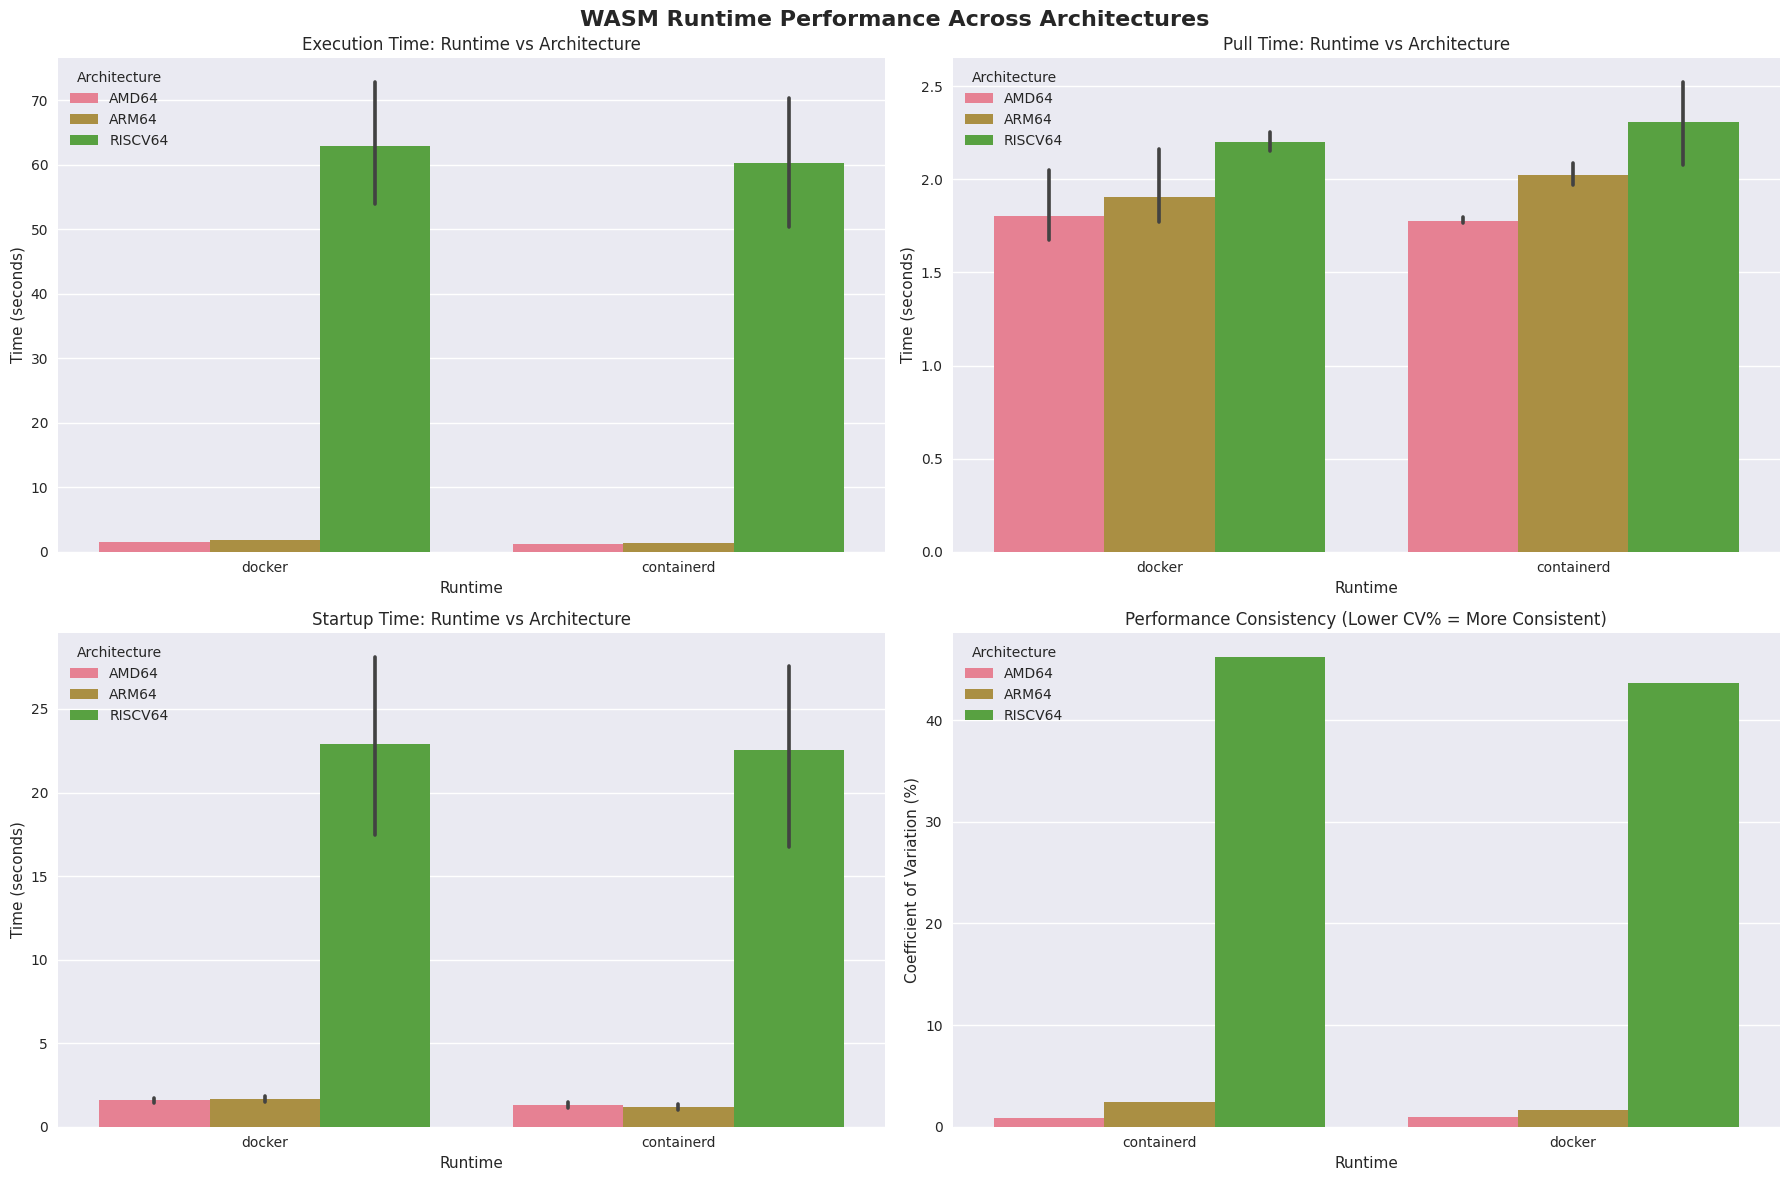


🚀 Runtime Rankings by Architecture:

AMD64:
  1. containerd: 1.264s
  2. docker: 1.525s

ARM64:
  1. containerd: 1.314s
  2. docker: 1.854s

RISCV64:
  1. containerd: 60.260s
  2. docker: 62.955s


In [6]:
if df is not None and has_architecture:
    wasm_df = df[df['Image Type'] == 'WebAssembly'].copy()
    
    if not wasm_df.empty:
        # Extract WASM runtime from Runtime column if it contains multiple runtimes
        # For now, use Runtime column directly since CSV doesn't have WASM_Runtime column
        print("📊 WASM Runtime Analysis:")
        print("=" * 40)
        
        # Show available WASM data
        wasm_summary = wasm_df.groupby(['Architecture', 'Runtime'])['Total Execution Time (s)'].agg(['mean', 'std', 'count']).round(3)
        print("WASM Performance by Architecture and Runtime:")
        display(wasm_summary)
        
        # Create visualization
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        fig.suptitle('WASM Runtime Performance Across Architectures', fontsize=16, fontweight='bold')
        
        # 1. Execution time by runtime and architecture
        ax1 = axes[0,0]
        sns.barplot(data=wasm_df, x='Runtime', y='Total Execution Time (s)', 
                   hue='Architecture', ax=ax1)
        ax1.set_title('Execution Time: Runtime vs Architecture')
        ax1.set_ylabel('Time (seconds)')
        
        # 2. Pull time comparison
        ax2 = axes[0,1] 
        sns.barplot(data=wasm_df, x='Runtime', y='Pull Time (s)', 
                   hue='Architecture', ax=ax2)
        ax2.set_title('Pull Time: Runtime vs Architecture')
        ax2.set_ylabel('Time (seconds)')
        
        # 3. Startup time (if available)
        ax3 = axes[1,0]
        startup_data = wasm_df[wasm_df['Container Start to Main Time (s)'].notna()]
        if not startup_data.empty:
            sns.barplot(data=startup_data, x='Runtime', y='Container Start to Main Time (s)', 
                       hue='Architecture', ax=ax3)
            ax3.set_title('Startup Time: Runtime vs Architecture')
            ax3.set_ylabel('Time (seconds)')
        else:
            ax3.text(0.5, 0.5, 'No startup timing data', ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('Startup Time - No Data')
        
        # 4. Performance consistency (coefficient of variation)
        ax4 = axes[1,1]
        consistency = wasm_df.groupby(['Architecture', 'Runtime'])['Total Execution Time (s)'].agg(
            lambda x: (x.std() / x.mean()) * 100 if x.mean() > 0 else 0
        ).reset_index()
        consistency.columns = ['Architecture', 'Runtime', 'CV_Percent']
        
        sns.barplot(data=consistency, x='Runtime', y='CV_Percent', hue='Architecture', ax=ax4)
        ax4.set_title('Performance Consistency (Lower CV% = More Consistent)')
        ax4.set_ylabel('Coefficient of Variation (%)')
        
        plt.tight_layout()
        plt.show()
        
        # Print runtime rankings by architecture
        print("\n🚀 Runtime Rankings by Architecture:")
        print("=" * 50)
        
        for arch in wasm_df['Architecture'].unique():
            arch_data = wasm_df[wasm_df['Architecture'] == arch]
            rankings = arch_data.groupby('Runtime')['Total Execution Time (s)'].mean().sort_values()
            print(f"\n{arch}:")
            for rank, (runtime, time_val) in enumerate(rankings.items(), 1):
                print(f"  {rank}. {runtime}: {time_val:.3f}s")
    else:
        print("❌ No WASM data available for analysis")
elif df is not None:
    print("⚠️ WASM runtime analysis not available for single-architecture dataset")

## Architecture-Specific Insights

In [7]:
if df is not None and has_architecture:
    print("\n🔬 ARCHITECTURE-SPECIFIC INSIGHTS")
    print("=" * 50)
    
    for arch in sorted(df['Architecture'].unique()):
        arch_data = df[df['Architecture'] == arch]
        
        print(f"\n🏗️ {arch} Analysis:")
        print("-" * 20)
        
        # Performance characteristics
        native_time = arch_data[arch_data['Image Type'] == 'Native']['Total Execution Time (s)'].mean()
        wasm_time = arch_data[arch_data['Image Type'] == 'WebAssembly']['Total Execution Time (s)'].mean()
        
        if pd.notna(native_time) and pd.notna(wasm_time) and native_time > 0:
            overhead = ((wasm_time / native_time) - 1) * 100
            print(f"• WASM overhead: {overhead:.1f}% vs native")
            
            if overhead > 200:
                print(f"  ⚠️ High WASM overhead - consider runtime optimization")
            elif overhead < 50:
                print(f"  ✅ Low WASM overhead - good performance")
        
        # Best runtime combination
        best_combo = arch_data.loc[arch_data['Total Execution Time (s)'].idxmin()]
        print(f"• Best combination: {best_combo['Runtime']} + {best_combo['Image Type']}")
        print(f"  Time: {best_combo['Total Execution Time (s)']:.3f}s")
        
        # Consistency analysis
        exec_times = arch_data['Total Execution Time (s)']
        cv = (exec_times.std() / exec_times.mean()) * 100 if exec_times.mean() > 0 else 0
        
        if cv < 10:
            print(f"• Performance consistency: Excellent ({cv:.1f}% CV)")
        elif cv < 25:
            print(f"• Performance consistency: Good ({cv:.1f}% CV)")
        else:
            print(f"• Performance consistency: Variable ({cv:.1f}% CV)")
        
        # Image size efficiency
        native_size = arch_data[arch_data['Image Type'] == 'Native']['Host Size (MB)'].mean()
        wasm_size = arch_data[arch_data['Image Type'] == 'WebAssembly']['Host Size (MB)'].mean()
        
        if pd.notna(native_size) and pd.notna(wasm_size) and native_size > 0:
            size_ratio = wasm_size / native_size
            if size_ratio < 1:
                print(f"• Image size: WASM {(1-size_ratio)*100:.1f}% smaller")
            else:
                print(f"• Image size: WASM {(size_ratio-1)*100:.1f}% larger")
    
    # Cross-architecture recommendations
    print("\n💡 CROSS-ARCHITECTURE RECOMMENDATIONS:")
    print("=" * 50)
    
    # Find universally best runtime
    runtime_scores = df.groupby('Runtime')['Total Execution Time (s)'].mean().sort_values()
    print(f"• Best overall runtime: {runtime_scores.index[0]} (avg: {runtime_scores.iloc[0]:.3f}s)")
    
    # Architecture-specific recommendations
    arch_best = df.groupby('Architecture')['Total Execution Time (s)'].mean().sort_values()
    print(f"• Fastest architecture: {arch_best.index[0]} (avg: {arch_best.iloc[0]:.3f}s)")
    print(f"• Consider {arch_best.index[0]} for performance-critical workloads")
    
    if len(arch_best) > 1:
        slowest_ratio = arch_best.iloc[-1] / arch_best.iloc[0]
        print(f"• Performance gap: {slowest_ratio:.1f}x between fastest and slowest")
        
elif df is not None:
    print("⚠️ Architecture-specific insights not available for single-architecture dataset")


🔬 ARCHITECTURE-SPECIFIC INSIGHTS

🏗️ AMD64 Analysis:
--------------------
• WASM overhead: 183.9% vs native
• Best combination: containerd + Native
  Time: 0.353s
• Performance consistency: Variable (50.2% CV)
• Image size: WASM 51.9% smaller

🏗️ ARM64 Analysis:
--------------------
• WASM overhead: 95.2% vs native
• Best combination: containerd + Native
  Time: 0.547s
• Performance consistency: Variable (39.1% CV)
• Image size: WASM 45.7% smaller

🏗️ RISCV64 Analysis:
--------------------
• WASM overhead: 1755.1% vs native
  ⚠️ High WASM overhead - consider runtime optimization
• Best combination: containerd + Native
  Time: 2.299s
• Performance consistency: Variable (73.9% CV)
• Image size: WASM 37.6% smaller

💡 CROSS-ARCHITECTURE RECOMMENDATIONS:
• Best overall runtime: containerd (avg: 23.440s)
• Fastest architecture: AMD64 (avg: 0.943s)
• Consider AMD64 for performance-critical workloads
• Performance gap: 49.9x between fastest and slowest


## Export Multi-Architecture Results

In [8]:
if df is not None:
    # Export comprehensive analysis
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    if has_architecture:
        # Multi-architecture summary
        arch_summary = df.groupby(['Architecture', 'Runtime', 'Image Type']).agg({
            'Pull Time (s)': ['mean', 'std'],
            'Total Execution Time (s)': ['mean', 'std'], 
            'Container Start to Main Time (s)': 'mean',
            'Host Size (MB)': 'mean'
        }).round(3)
        
        arch_summary.to_csv(f'multiarch_summary_{timestamp}.csv')
        print(f"✅ Multi-architecture summary exported to: multiarch_summary_{timestamp}.csv")
        
        # Runtime comparison (using Runtime column instead of WASM_Runtime)
        wasm_data = df[df['Image Type'] == 'WebAssembly']
        if not wasm_data.empty:
            runtime_comparison = wasm_data.groupby(
                ['Architecture', 'Runtime']
            )['Total Execution Time (s)'].agg(['mean', 'std', 'count']).round(3)
            
            runtime_comparison.to_csv(f'runtime_comparison_{timestamp}.csv')
            print(f"✅ Runtime comparison exported to: runtime_comparison_{timestamp}.csv")
    
    # Export enhanced dataset with analysis columns
    df.to_csv(f'enhanced_timing_analysis_{timestamp}.csv', index=False)
    print(f"✅ Enhanced dataset exported to: enhanced_timing_analysis_{timestamp}.csv")
    
    print(f"\n📁 Generated analysis files:")
    if has_architecture:
        print(f"   • multiarch_summary_{timestamp}.csv - Cross-architecture performance summary")
        wasm_data = df[df['Image Type'] == 'WebAssembly']
        if not wasm_data.empty:
            print(f"   • runtime_comparison_{timestamp}.csv - Runtime performance comparison")
    print(f"   • enhanced_timing_analysis_{timestamp}.csv - Complete dataset with analysis")
    print(f"   • analyze_multiarch_results.ipynb - This analysis notebook")
    
print("\n🎉 Multi-architecture analysis complete!")

if df is not None and has_architecture:
    print("\n📊 Key Takeaways:")
    print("• Compare performance characteristics across different CPU architectures")
    print("• Identify the best runtime for each architecture")
    print("• Understand architecture-specific optimization opportunities")
    print("• Make informed decisions for multi-architecture deployments")
    
    print("\n💡 Next Steps:")
    print("• Use venv environment: source venv/bin/activate")
    print("• View results in Jupyter: jupyter notebook")
    print("• Combine new results: python3 combine_results.py")

✅ Multi-architecture summary exported to: multiarch_summary_20250807_063707.csv
✅ Runtime comparison exported to: runtime_comparison_20250807_063707.csv
✅ Enhanced dataset exported to: enhanced_timing_analysis_20250807_063707.csv

📁 Generated analysis files:
   • multiarch_summary_20250807_063707.csv - Cross-architecture performance summary
   • runtime_comparison_20250807_063707.csv - Runtime performance comparison
   • enhanced_timing_analysis_20250807_063707.csv - Complete dataset with analysis
   • analyze_multiarch_results.ipynb - This analysis notebook

🎉 Multi-architecture analysis complete!

📊 Key Takeaways:
• Compare performance characteristics across different CPU architectures
• Identify the best runtime for each architecture
• Understand architecture-specific optimization opportunities
• Make informed decisions for multi-architecture deployments

💡 Next Steps:
• Use venv environment: source venv/bin/activate
• View results in Jupyter: jupyter notebook
• Combine new results: